# Classification of Neutrophils Across Multiple Seeds (ResNet34)

# Import Libraries

In [31]:
# Import libraries
import torch
import os
import random
import numpy as np
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from torch import nn, optim
from torchvision.models import ResNet34_Weights
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight


# Device Configuration

In [2]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


# Define Paths and Constants

In [3]:
# Paths to directories
healthy_dir = '/Users/irdynaumaira/Downloads/CompSci_MSc-project/Images/Healthy'
nets_dir = '/Users/irdynaumaira/Downloads/CompSci_MSc-project/Images/NETs'
class_names = ['Healthy', 'NETs']
image_size = (224, 224)

# Define CLAHE (Contrast Limited Adaptive Histogram Equalization)

In [4]:
# CLAHE Function 
def apply_clahe(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(image)


# Preview CLAHE 

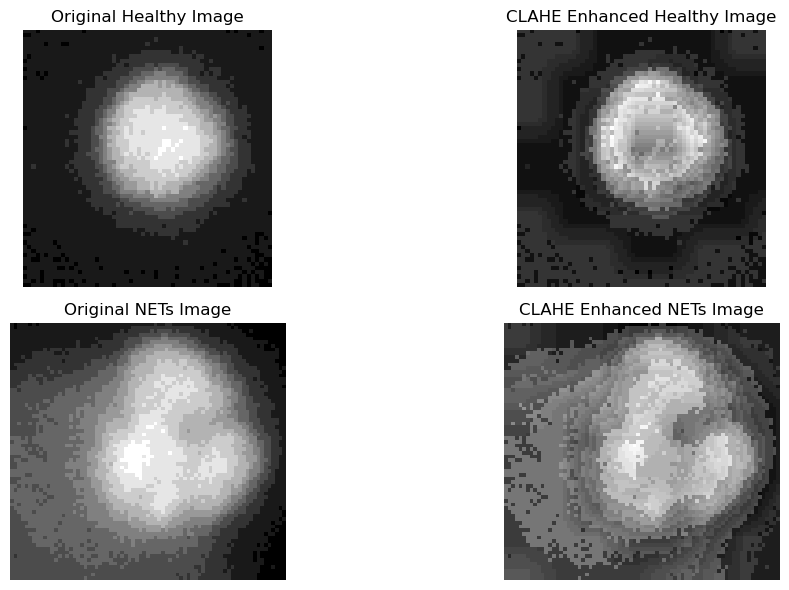

In [69]:


def apply_clahe(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(image)

def preview_clahe(healthy_images, nets_images):
    plt.figure(figsize=(12, 6))

    # Select one random image from each category
    healthy_image = random.choice(healthy_images)
    nets_image = random.choice(nets_images)

    # CLAHE Enhanced Healthy Image
    enhanced_healthy = apply_clahe(healthy_image)

    # CLAHE Enhanced NETs Image
    enhanced_nets = apply_clahe(nets_image)

    # Plotting
    plt.subplot(2, 2, 1)
    plt.imshow(healthy_image, cmap='gray')
    plt.title('Original Healthy Image')
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.imshow(enhanced_healthy, cmap='gray')
    plt.title('CLAHE Enhanced Healthy Image')
    plt.axis('off')

    plt.subplot(2, 2, 3)
    plt.imshow(nets_image, cmap='gray')
    plt.title('Original NETs Image')
    plt.axis('off')

    plt.subplot(2, 2, 4)
    plt.imshow(enhanced_nets, cmap='gray')
    plt.title('CLAHE Enhanced NETs Image')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Load images for preview
healthy_images = [cv2.imread(os.path.join(healthy_dir, f), cv2.IMREAD_GRAYSCALE) for f in os.listdir(healthy_dir) if f.endswith('.tif')]
nets_images = [cv2.imread(os.path.join(nets_dir, f), cv2.IMREAD_GRAYSCALE) for f in os.listdir(nets_dir) if f.endswith('.tif')]

# Preview CLAHE for one image from each category
preview_clahe(healthy_images, nets_images)

# Load and Preprocess Data

In [5]:
# Load and preprocess data with CLAHE
def load_data():
    images, labels = [], []
    for folder, label in zip([healthy_dir, nets_dir], [0, 1]):  # 0: Healthy, 1: NETs
        for file in tqdm(os.listdir(folder)):
            img_path = os.path.join(folder, file)
            image = cv2.imread(img_path)
            if image is None:
                continue
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, image_size)
            gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            enhanced_image = apply_clahe(gray_image)
            images.append(enhanced_image)
            labels.append(label)
    images = np.array(images, dtype='float32') / 255.0  # Normalize
    labels = np.array(labels, dtype='int64')
    return images, labels

# Load the data
images, labels = load_data()
print("Data is successfully loaded.")


100%|██████████| 784/784 [00:01<00:00, 440.75it/s]


Data is successfully loaded.


# Define Dataset Class 

In [6]:
# Dataset class
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images, self.labels = images, labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Convert grayscale to RGB
        image = cv2.cvtColor(self.images[idx], cv2.COLOR_GRAY2RGB)
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        else:
            image = transforms.ToTensor()(image)
        return image, label


# Data Augmentation and Transformation

In [7]:
# Data augmentation and transformation
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(108),
    transforms.RandomResizedCrop(image_size, scale=(0.7, 1.3)),
    transforms.ColorJitter(contrast=(0.7, 1.3)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),  # Standard normalization for ImageNet
])

# Preview Augmented Image

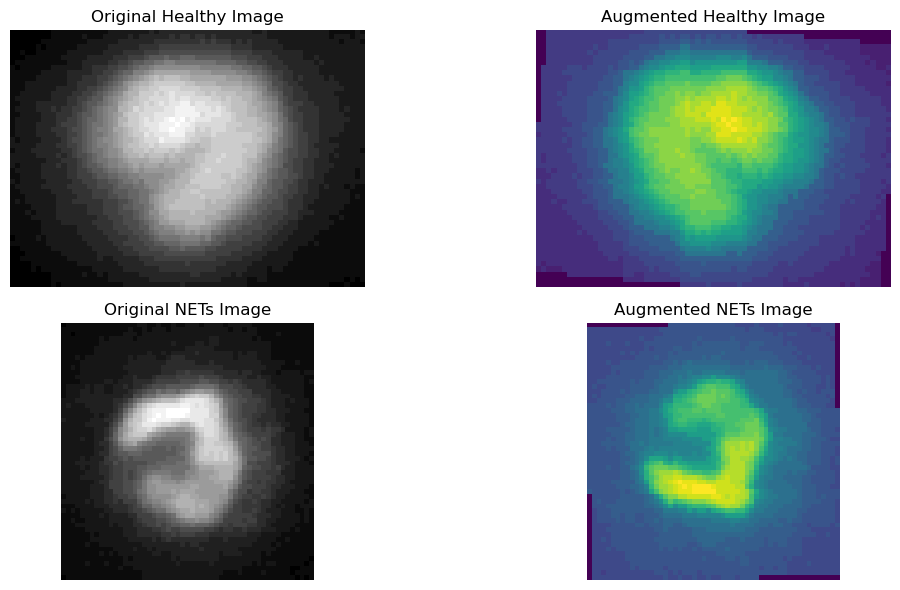

In [68]:

from PIL import Image


def transform_image(image):
    # Convert image to PIL format for torchvision transformations
    image_pil = Image.fromarray(image)
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.1, contrast=0.1),
        transforms.ToTensor(),
    ])
    return transform(image_pil)

def preview_augmentation(healthy_images, nets_images):
    plt.figure(figsize=(12, 6))

    # Select one random image from each category
    healthy_image = random.choice(healthy_images)
    nets_image = random.choice(nets_images)

    # Augmented Healthy Image
    augmented_healthy = transform_image(healthy_image)

    # Augmented NETs Image
    augmented_nets = transform_image(nets_image)

    # Plotting
    plt.subplot(2, 2, 1)
    plt.imshow(healthy_image, cmap='gray')
    plt.title('Original Healthy Image')
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.imshow(augmented_healthy.permute(1, 2, 0))  # Convert back to HWC format
    plt.title('Augmented Healthy Image')
    plt.axis('off')

    plt.subplot(2, 2, 3)
    plt.imshow(nets_image, cmap='gray')
    plt.title('Original NETs Image')
    plt.axis('off')

    plt.subplot(2, 2, 4)
    plt.imshow(augmented_nets.permute(1, 2, 0))  # Convert back to HWC format
    plt.title('Augmented NETs Image')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Load images for preview
healthy_images = [cv2.imread(os.path.join(healthy_dir, f), cv2.IMREAD_GRAYSCALE) for f in os.listdir(healthy_dir) if f.endswith('.tif')]
nets_images = [cv2.imread(os.path.join(nets_dir, f), cv2.IMREAD_GRAYSCALE) for f in os.listdir(nets_dir) if f.endswith('.tif')]

# Preview Data Augmentation for one image from each category
preview_augmentation(healthy_images, nets_images)

# Set Random Seeds For Reproducibility 

In [8]:
# Function to set random seeds for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# Define Model and Load Pre-trained ResNet34

In [15]:


# Function to load pre-trained ResNet34 model and modify for binary classification
def load_resnet34():
    weights = ResNet34_Weights.IMAGENET1K_V1
    model = models.resnet34(weights=weights)
    

    # Modify the final fully connected layer for binary classification
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 2)

    # Freeze all layers except the final fully connected layer
    for name, param in model.named_parameters():
        if "fc" in name:
            param.requires_grad = True
        else:
            param.requires_grad = False

    return model.to(device)


# Print Model Summary

In [24]:
# Print the model structure
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Training Function

In [33]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for images_batch, labels_batch in train_loader:
            images_batch, labels_batch = images_batch.to(device), labels_batch.to(device)
            optimizer.zero_grad()
            outputs = model(images_batch)
            loss = criterion(outputs, labels_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels_batch.size(0)
            correct += (predicted == labels_batch).sum().item()

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(100 * correct / total)

        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images_batch, labels_batch in val_loader:
                images_batch, labels_batch = images_batch.to(device), labels_batch.to(device)
                outputs = model(images_batch)
                loss = criterion(outputs, labels_batch)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels_batch.size(0)
                val_correct += (predicted == labels_batch).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(100 * val_correct / val_total)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_losses[-1]:.4f}, "
              f"Val Loss: {val_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, "
              f"Val Acc: {val_accuracies[-1]:.2f}%")

    return train_losses, val_losses, train_accuracies, val_accuracies



# Experiment with Multiple Seeds
- Stratified Data Splitting 
- Create Datasets and Dataloaders
- Compute Class Weights
- Instatiate Criterion and Optimizer
- Train the Model and Evaluate the Model on Test Data
- Confusion Matrix and Plot Accuracy and Loss over Epochs for Each Seed


Running with seed: 42


/Users/irdynaumaira/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/irdynaumaira/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/100] - Train Loss: 0.6966, Val Loss: 0.6482, Train Acc: 57.45%, Val Acc: 60.92%
Epoch [2/100] - Train Loss: 0.6805, Val Loss: 0.7052, Train Acc: 58.89%, Val Acc: 53.45%
Epoch [3/100] - Train Loss: 0.6787, Val Loss: 0.6745, Train Acc: 60.55%, Val Acc: 58.62%
Epoch [4/100] - Train Loss: 0.6698, Val Loss: 0.6671, Train Acc: 61.05%, Val Acc: 55.75%
Epoch [5/100] - Train Loss: 0.7263, Val Loss: 0.6503, Train Acc: 57.31%, Val Acc: 60.92%
Epoch [6/100] - Train Loss: 0.7209, Val Loss: 0.6916, Train Acc: 57.24%, Val Acc: 63.22%
Epoch [7/100] - Train Loss: 0.7066, Val Loss: 0.6666, Train Acc: 58.32%, Val Acc: 59.20%
Epoch [8/100] - Train Loss: 0.6512, Val Loss: 0.7635, Train Acc: 62.99%, Val Acc: 60.34%
Epoch [9/100] - Train Loss: 0.6742, Val Loss: 0.6526, Train Acc: 60.19%, Val Acc: 64.94%
Epoch [10/100] - Train Loss: 0.6504, Val Loss: 0.6542, Train Acc: 62.49%, Val Acc: 60.34%
Epoch [11/100] - Train Loss: 0.6585, Val Loss: 0.6439, Train Acc: 61.12%, Val Acc: 62.07%
Epoch [12/100] - Tr

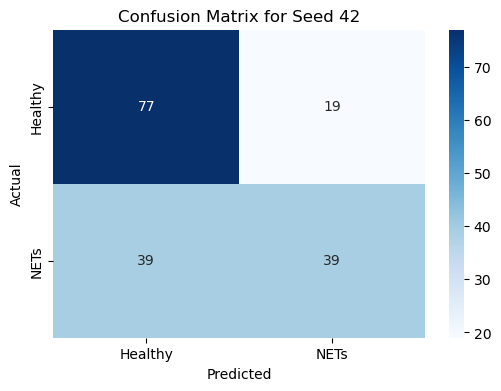

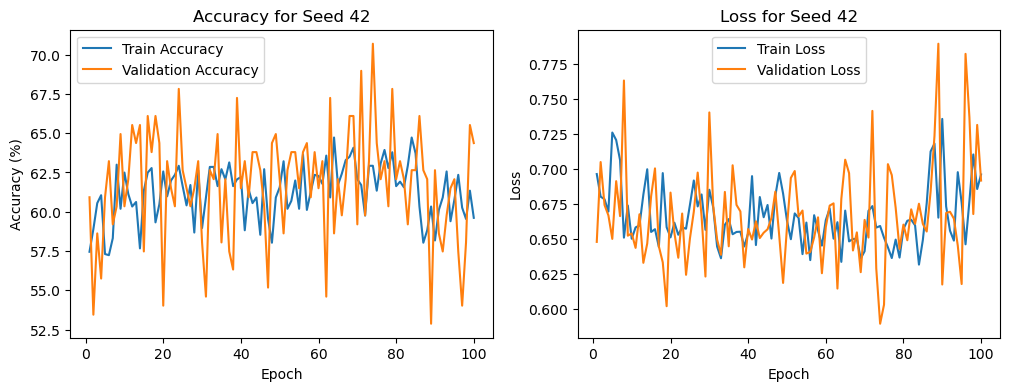


Running with seed: 256


/Users/irdynaumaira/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/irdynaumaira/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/100] - Train Loss: 0.7316, Val Loss: 0.6580, Train Acc: 53.06%, Val Acc: 57.47%
Epoch [2/100] - Train Loss: 0.6880, Val Loss: 0.6383, Train Acc: 57.67%, Val Acc: 64.37%
Epoch [3/100] - Train Loss: 0.7222, Val Loss: 0.6843, Train Acc: 54.36%, Val Acc: 55.17%
Epoch [4/100] - Train Loss: 0.6914, Val Loss: 0.6657, Train Acc: 58.17%, Val Acc: 60.34%
Epoch [5/100] - Train Loss: 0.6806, Val Loss: 0.7319, Train Acc: 58.03%, Val Acc: 58.62%
Epoch [6/100] - Train Loss: 0.6713, Val Loss: 0.6717, Train Acc: 61.84%, Val Acc: 58.05%
Epoch [7/100] - Train Loss: 0.6501, Val Loss: 0.6375, Train Acc: 61.84%, Val Acc: 62.64%
Epoch [8/100] - Train Loss: 0.6532, Val Loss: 0.6886, Train Acc: 60.98%, Val Acc: 61.49%
Epoch [9/100] - Train Loss: 0.6731, Val Loss: 0.6431, Train Acc: 60.98%, Val Acc: 61.49%
Epoch [10/100] - Train Loss: 0.6685, Val Loss: 0.6936, Train Acc: 59.76%, Val Acc: 59.20%
Epoch [11/100] - Train Loss: 0.6743, Val Loss: 0.6680, Train Acc: 61.27%, Val Acc: 59.77%
Epoch [12/100] - Tr

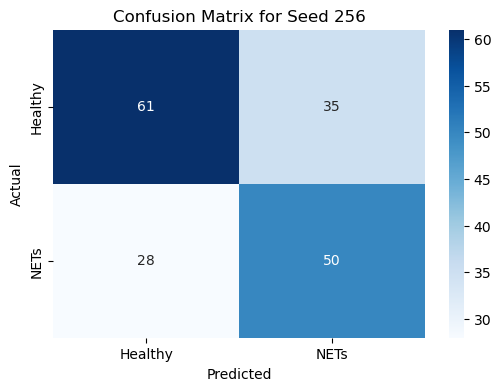

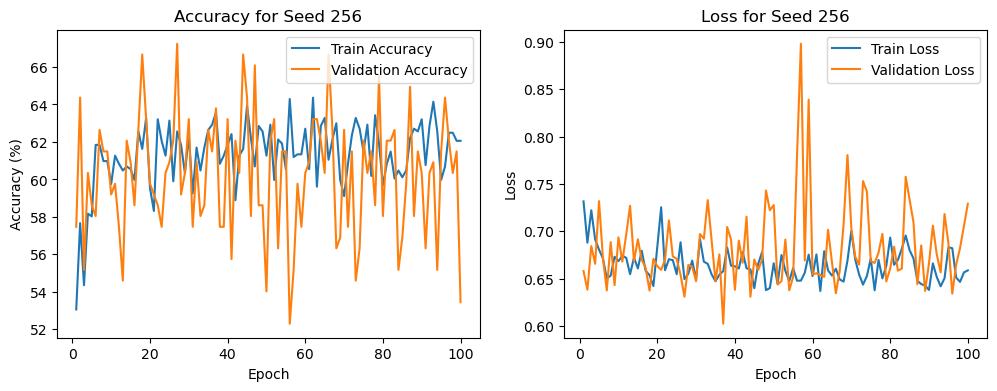


Running with seed: 282


/Users/irdynaumaira/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/irdynaumaira/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/100] - Train Loss: 0.7114, Val Loss: 0.7320, Train Acc: 55.65%, Val Acc: 46.55%
Epoch [2/100] - Train Loss: 0.6924, Val Loss: 0.7875, Train Acc: 57.67%, Val Acc: 56.32%
Epoch [3/100] - Train Loss: 0.6658, Val Loss: 0.7074, Train Acc: 60.19%, Val Acc: 56.90%
Epoch [4/100] - Train Loss: 0.6732, Val Loss: 0.6373, Train Acc: 59.97%, Val Acc: 59.20%
Epoch [5/100] - Train Loss: 0.6652, Val Loss: 0.6878, Train Acc: 61.20%, Val Acc: 60.34%
Epoch [6/100] - Train Loss: 0.6625, Val Loss: 0.6866, Train Acc: 61.70%, Val Acc: 53.45%
Epoch [7/100] - Train Loss: 0.6835, Val Loss: 0.7258, Train Acc: 58.60%, Val Acc: 57.47%
Epoch [8/100] - Train Loss: 0.6913, Val Loss: 0.6626, Train Acc: 58.89%, Val Acc: 64.37%
Epoch [9/100] - Train Loss: 0.6599, Val Loss: 0.7483, Train Acc: 61.34%, Val Acc: 55.17%
Epoch [10/100] - Train Loss: 0.6637, Val Loss: 0.6613, Train Acc: 61.12%, Val Acc: 60.92%
Epoch [11/100] - Train Loss: 0.6581, Val Loss: 0.7174, Train Acc: 62.49%, Val Acc: 58.05%
Epoch [12/100] - Tr

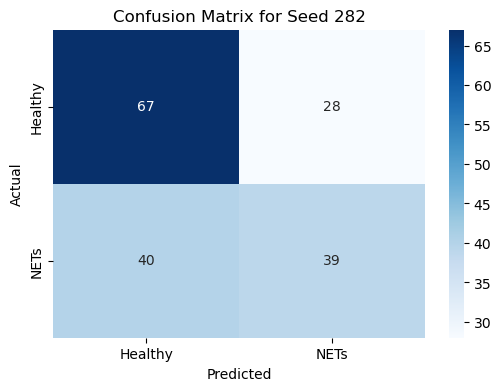

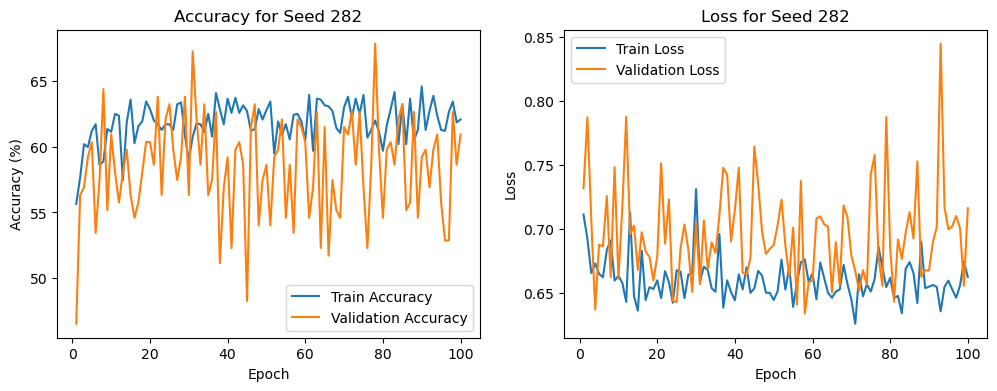


Running with seed: 382


/Users/irdynaumaira/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/irdynaumaira/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/100] - Train Loss: 0.7408, Val Loss: 0.6651, Train Acc: 53.49%, Val Acc: 61.49%
Epoch [2/100] - Train Loss: 0.6658, Val Loss: 0.6276, Train Acc: 60.26%, Val Acc: 61.49%
Epoch [3/100] - Train Loss: 0.6669, Val Loss: 0.6323, Train Acc: 60.12%, Val Acc: 66.09%
Epoch [4/100] - Train Loss: 0.6784, Val Loss: 0.6417, Train Acc: 60.26%, Val Acc: 58.62%
Epoch [5/100] - Train Loss: 0.6836, Val Loss: 0.6596, Train Acc: 60.19%, Val Acc: 64.37%
Epoch [6/100] - Train Loss: 0.6730, Val Loss: 0.6088, Train Acc: 60.84%, Val Acc: 68.97%
Epoch [7/100] - Train Loss: 0.6472, Val Loss: 0.6290, Train Acc: 63.64%, Val Acc: 67.24%
Epoch [8/100] - Train Loss: 0.7037, Val Loss: 0.6181, Train Acc: 57.38%, Val Acc: 68.97%
Epoch [9/100] - Train Loss: 0.6667, Val Loss: 0.6223, Train Acc: 59.83%, Val Acc: 67.24%
Epoch [10/100] - Train Loss: 0.6543, Val Loss: 0.6173, Train Acc: 62.56%, Val Acc: 66.09%
Epoch [11/100] - Train Loss: 0.6447, Val Loss: 0.5756, Train Acc: 62.56%, Val Acc: 72.41%
Epoch [12/100] - Tr

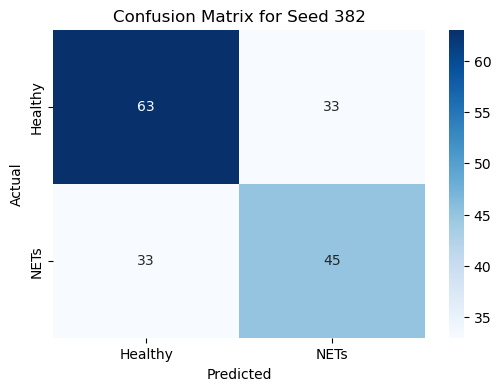

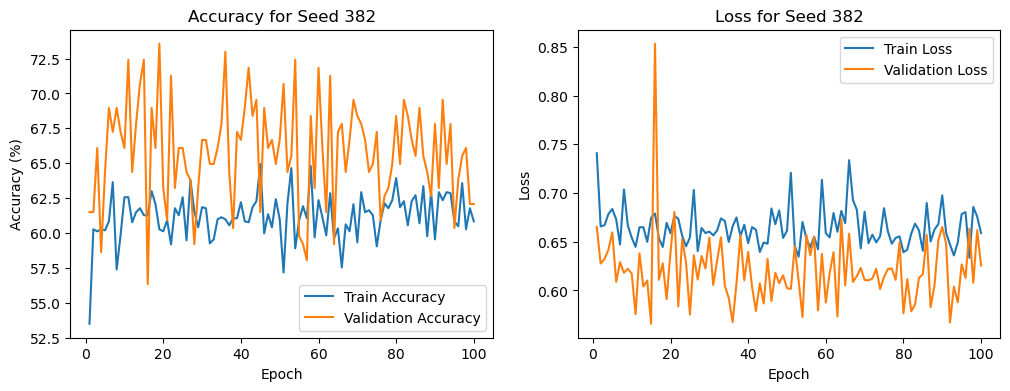


Running with seed: 404


/Users/irdynaumaira/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/irdynaumaira/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/100] - Train Loss: 0.7555, Val Loss: 0.6831, Train Acc: 52.27%, Val Acc: 58.05%
Epoch [2/100] - Train Loss: 0.6850, Val Loss: 0.6998, Train Acc: 57.88%, Val Acc: 54.02%
Epoch [3/100] - Train Loss: 0.6596, Val Loss: 0.6424, Train Acc: 60.55%, Val Acc: 59.77%
Epoch [4/100] - Train Loss: 0.6707, Val Loss: 0.6532, Train Acc: 61.41%, Val Acc: 60.34%
Epoch [5/100] - Train Loss: 0.6552, Val Loss: 0.6195, Train Acc: 61.63%, Val Acc: 59.20%
Epoch [6/100] - Train Loss: 0.6444, Val Loss: 0.6459, Train Acc: 62.85%, Val Acc: 60.34%
Epoch [7/100] - Train Loss: 0.6733, Val Loss: 0.6364, Train Acc: 61.20%, Val Acc: 59.77%
Epoch [8/100] - Train Loss: 0.6709, Val Loss: 0.6705, Train Acc: 60.12%, Val Acc: 59.20%
Epoch [9/100] - Train Loss: 0.6693, Val Loss: 0.7083, Train Acc: 59.40%, Val Acc: 56.32%
Epoch [10/100] - Train Loss: 0.6724, Val Loss: 0.6325, Train Acc: 60.55%, Val Acc: 58.62%
Epoch [11/100] - Train Loss: 0.6619, Val Loss: 0.6520, Train Acc: 61.56%, Val Acc: 63.79%
Epoch [12/100] - Tr

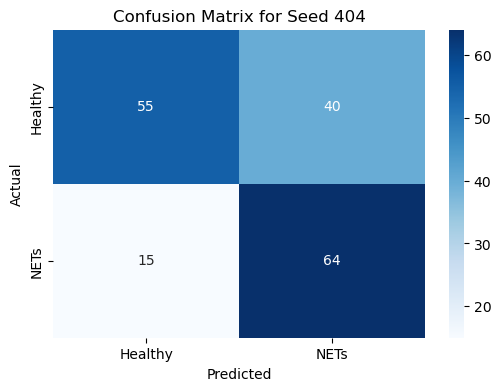

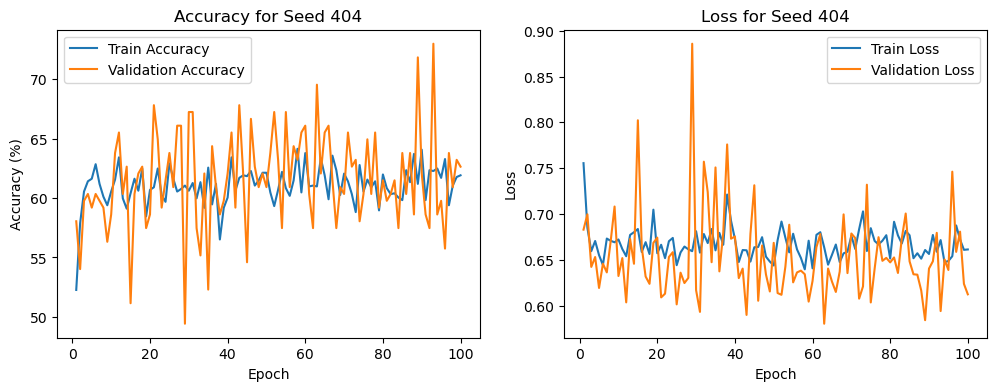

In [35]:
# Seeds for experiments
seeds = [42, 256, 282, 382, 404]

# Initialize metrics lists
all_train_accuracies = []
all_val_accuracies = []
all_test_accuracies = []
all_test_precisions = []
all_test_recalls = []
all_test_f1s = []

for seed in seeds:
    print(f"\nRunning with seed: {seed}")
    set_seed(seed)

    # Stratified splitting
    train_images, test_images, train_labels, test_labels = train_test_split(
        images, labels, test_size=0.2, random_state=seed, stratify=labels)
    val_images, test_images, val_labels, test_labels = train_test_split(
        test_images, test_labels, test_size=0.5, random_state=seed, stratify=test_labels)

    # Create datasets and dataloaders
    train_dataset = CustomDataset(train_images, train_labels, transform)
    val_dataset = CustomDataset(val_images, val_labels, transform)
    test_dataset = CustomDataset(test_images, test_labels, transform)

    train_loader = DataLoader(train_dataset, batch_size=30, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Load ResNet34 model
    model = models.resnet34(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 2)

    # Freeze all layers except the final fully connected layer
    for param in model.parameters():
        param.requires_grad = False
    for param in model.fc.parameters():
        param.requires_grad = True

    # Send model to device
    model = model.to(device)

    # Compute class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

    # Criterion and optimizer
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=0.0015, weight_decay=0.0001)

    # Train the model
    train_losses, val_losses, train_accuracies, val_accuracies = train_model(
        model, train_loader, val_loader, criterion, optimizer, num_epochs=100)

    # Test evaluation
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for images_batch, labels_batch in test_loader:
            images_batch, labels_batch = images_batch.to(device), labels_batch.to(device)
            outputs = model(images_batch)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(labels_batch.cpu().numpy())

    # Accuracy and metrics
    test_accuracy = 100 * np.sum(np.array(all_preds) == np.array(all_targets)) / len(all_targets)
    all_test_accuracies.append(test_accuracy)

    report = classification_report(all_targets, all_preds, target_names=class_names, output_dict=True)
    all_test_precisions.append(report['weighted avg']['precision'])
    all_test_recalls.append(report['weighted avg']['recall'])
    all_test_f1s.append(report['weighted avg']['f1-score'])

    print(f"Test Accuracy for seed {seed}: {test_accuracy:.2f}%")

    # Confusion Matrix
    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix for Seed {seed}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Plot training and validation accuracy
    epochs_range = range(1, 101)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
    plt.title(f'Accuracy for Seed {seed}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.title(f'Loss for Seed {seed}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


# Overall Performance Metrics and Box Plots


In [53]:
# Calculate and print average metrics
def calculate_mean_and_std(values):
    mean = np.mean(values)
    std = np.std(values)
    return mean, std

metrics = {
    "Test Accuracy (%)": all_test_accuracies,
    "Precision": all_test_precisions,
    "Recall": all_test_recalls,
    "F1-Score": all_test_f1s,
}

for metric_name, values in metrics.items():
    mean, std = calculate_mean_and_std(values)
    print(f'Average {metric_name}: {mean:.2f} ± {std:.2f}')


Average Test Accuracy (%): 64.37 ± 2.79
Average Precision: 0.65 ± 0.04
Average Recall: 0.64 ± 0.03
Average F1-Score: 0.64 ± 0.03


# Plot Box Plot for Test Accuracy across Different Seeds

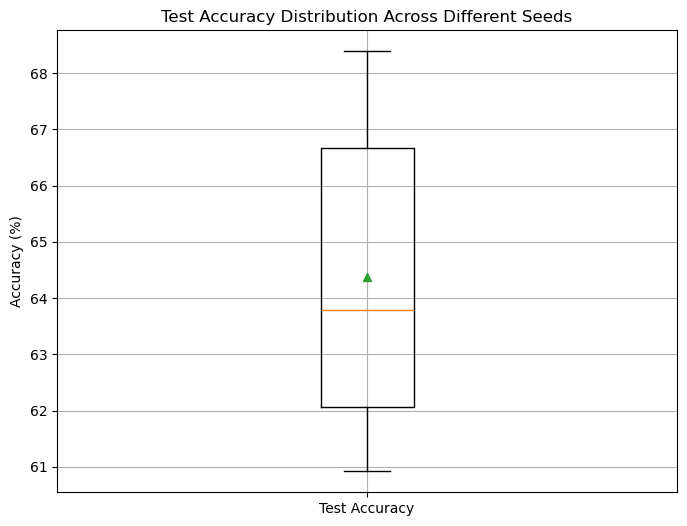

In [45]:
# Plot box plot for Test Accuracy across different seeds 
plt.figure(figsize=(8, 6))
plt.boxplot(all_test_accuracies, tick_labels=['Test Accuracy'], showmeans=True)
plt.title('Test Accuracy Distribution Across Different Seeds')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.show()


# Plot box plots for Precision, Recall, F1-Score across Different Seeds

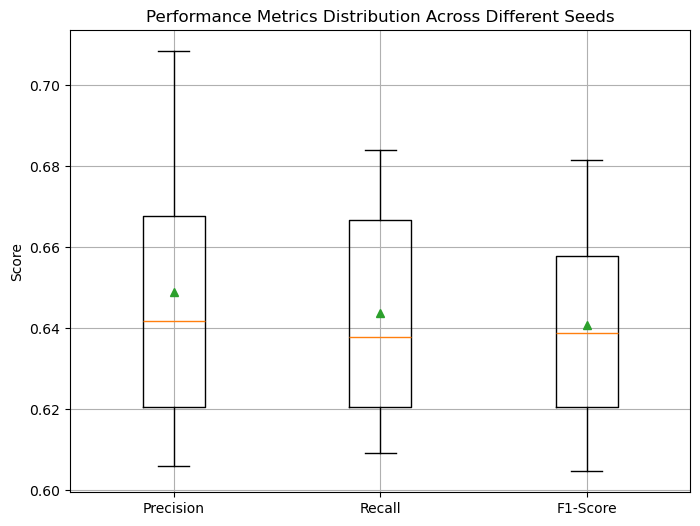

In [51]:
# Plot box plots for Precision, Recall, F1-Score across Different Seeds
plt.figure(figsize=(8, 6))
metrics_data = [all_test_precisions, all_test_recalls, all_test_f1s]
plt.boxplot(metrics_data, tick_labels=['Precision', 'Recall', 'F1-Score'], showmeans=True)
plt.title('Performance Metrics Distribution Across Different Seeds')
plt.ylabel('Score')
plt.grid(True)
plt.show()


# One Page Code

In [ ]:
# Import libraries
import torch
import os
import random
import numpy as np
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from torch import nn, optim
from torchvision.models import ResNet34_Weights
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Paths to directories
healthy_dir = '/Users/irdynaumaira/Downloads/CompSci_MSc-project/Images/Healthy'
nets_dir = '/Users/irdynaumaira/Downloads/CompSci_MSc-project/Images/NETs'
class_names = ['Healthy', 'NETs']
image_size = (224, 224)

# CLAHE (Contrast Limited Adaptive Histogram Equalization)
def apply_clahe(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(image)

# Load and preprocess data with CLAHE
def load_data():
    images, labels = [], []
    for folder, label in zip([healthy_dir, nets_dir], [0, 1]):  # 0: Healthy, 1: NETs
        for file in tqdm(os.listdir(folder)):
            img_path = os.path.join(folder, file)
            image = cv2.imread(img_path)
            if image is None:
                continue
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, image_size)
            gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            enhanced_image = apply_clahe(gray_image)
            images.append(enhanced_image)
            labels.append(label)
    images = np.array(images, dtype='float32') / 255.0  # Normalize
    labels = np.array(labels, dtype='int64')
    return images, labels

# Load the data
images, labels = load_data()
print("Data is successfully loaded.")

# Dataset class
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images, self.labels = images, labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Convert grayscale to RGB
        image = cv2.cvtColor(self.images[idx], cv2.COLOR_GRAY2RGB)
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        else:
            image = transforms.ToTensor()(image)
        return image, label

# Data augmentation and transformation
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(108),
    transforms.RandomResizedCrop(image_size, scale=(0.7, 1.3)),
    transforms.ColorJitter(contrast=(0.7, 1.3)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),  # Standard normalization for ImageNet
])

# Function to set random seeds for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Function to load pre-trained ResNet34 model and modify for binary classification
def load_resnet34():
    weights = ResNet34_Weights.IMAGENET1K_V1
    model = models.resnet34(weights=weights)
    

    # Modify the final fully connected layer for binary classification
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 2)

    # Freeze all layers except the final fully connected layer
    for name, param in model.named_parameters():
        if "fc" in name:
            param.requires_grad = True
        else:
            param.requires_grad = False

    return model.to(device)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for images_batch, labels_batch in train_loader:
            images_batch, labels_batch = images_batch.to(device), labels_batch.to(device)
            optimizer.zero_grad()
            outputs = model(images_batch)
            loss = criterion(outputs, labels_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels_batch.size(0)
            correct += (predicted == labels_batch).sum().item()

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(100 * correct / total)

        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images_batch, labels_batch in val_loader:
                images_batch, labels_batch = images_batch.to(device), labels_batch.to(device)
                outputs = model(images_batch)
                loss = criterion(outputs, labels_batch)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels_batch.size(0)
                val_correct += (predicted == labels_batch).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(100 * val_correct / val_total)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_losses[-1]:.4f}, "
              f"Val Loss: {val_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, "
              f"Val Acc: {val_accuracies[-1]:.2f}%")

    return train_losses, val_losses, train_accuracies, val_accuracies

# Seeds for experiments
seeds = [42, 256, 282, 382, 404]

# Initialize metrics lists
all_train_accuracies = []
all_val_accuracies = []
all_test_accuracies = []
all_test_precisions = []
all_test_recalls = []
all_test_f1s = []

for seed in seeds:
    print(f"\nRunning with seed: {seed}")
    set_seed(seed)

    # Stratified splitting
    train_images, test_images, train_labels, test_labels = train_test_split(
        images, labels, test_size=0.2, random_state=seed, stratify=labels)
    val_images, test_images, val_labels, test_labels = train_test_split(
        test_images, test_labels, test_size=0.5, random_state=seed, stratify=test_labels)

    # Create datasets and dataloaders
    train_dataset = CustomDataset(train_images, train_labels, transform)
    val_dataset = CustomDataset(val_images, val_labels, transform)
    test_dataset = CustomDataset(test_images, test_labels, transform)

    train_loader = DataLoader(train_dataset, batch_size=30, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Load ResNet34 model
    model = models.resnet34(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 2)

    # Freeze all layers except the final fully connected layer
    for param in model.parameters():
        param.requires_grad = False
    for param in model.fc.parameters():
        param.requires_grad = True

    # Send model to device
    model = model.to(device)

    # Compute class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

    # Criterion and optimizer
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=0.0015, weight_decay=0.0001)

    # Train the model
    train_losses, val_losses, train_accuracies, val_accuracies = train_model(
        model, train_loader, val_loader, criterion, optimizer, num_epochs=100)

    # Test evaluation
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for images_batch, labels_batch in test_loader:
            images_batch, labels_batch = images_batch.to(device), labels_batch.to(device)
            outputs = model(images_batch)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(labels_batch.cpu().numpy())

    # Accuracy and metrics
    test_accuracy = 100 * np.sum(np.array(all_preds) == np.array(all_targets)) / len(all_targets)
    all_test_accuracies.append(test_accuracy)

    report = classification_report(all_targets, all_preds, target_names=class_names, output_dict=True)
    all_test_precisions.append(report['weighted avg']['precision'])
    all_test_recalls.append(report['weighted avg']['recall'])
    all_test_f1s.append(report['weighted avg']['f1-score'])

    print(f"Test Accuracy for seed {seed}: {test_accuracy:.2f}%")

    # Confusion Matrix
    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix for Seed {seed}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Plot training and validation accuracy
    epochs_range = range(1, 101)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
    plt.title(f'Accuracy for Seed {seed}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.title(f'Loss for Seed {seed}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Calculate and print average metrics
def calculate_mean_and_std(values):
    mean = np.mean(values)
    std = np.std(values)
    return mean, std

metrics = {
    "Test Accuracy (%)": all_test_accuracies,
    "Precision": all_test_precisions,
    "Recall": all_test_recalls,
    "F1-Score": all_test_f1s,
}

for metric_name, values in metrics.items():
    mean, std = calculate_mean_and_std(values)
    print(f'Average {metric_name}: {mean:.2f} ± {std:.2f}')

# Plot box plot for Test Accuracy across different seeds 
plt.figure(figsize=(8, 6))
plt.boxplot(all_test_accuracies, tick_labels=['Test Accuracy'], showmeans=True)
plt.title('Test Accuracy Distribution Across Different Seeds')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.show()

# Plot box plots for Precision, Recall, F1-Score across Different Seeds
plt.figure(figsize=(8, 6))
metrics_data = [all_test_precisions, all_test_recalls, all_test_f1s]
plt.boxplot(metrics_data, tick_labels=['Precision', 'Recall', 'F1-Score'], showmeans=True)
plt.title('Performance Metrics Distribution Across Different Seeds')
plt.ylabel('Score')
plt.grid(True)
plt.show()